In [148]:
#import data from sources
import pandas as pd
from functools import reduce
import requests 
import os
import pathlib
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import random
from tabulate import tabulate

# Step 1 : Gather Data
- Call EIA.gov API
    - Set the api key 
    - Set the start and end month in 'YYYYMM' format

- Average Consumption Dataset :
    - Retail sales of electricity, Florida, residential, monthly
    - Units in Million Kilowatthours
    - Conversion to kWh : X_kWh = (X * 10^6)

- Average Prosumer Generation Dataset :
    - Net generation, small-scale solar photovoltaic, Florida , residential, monthly
    - Units in thousand megawatthours
    - Conversion to kWh : X_kWh = (X * 10^3 * 10^3)
    
- Average  Price Dataset:
    - Average retail price of electricity, Florida, monthly
    - Units in cents per Kilowatthour
    - Conversion to cents/kWh : X_cents/kWh = X_cents/kWh


     time    demand  generation  price
9  202001  0.619526    0.608698  11.73
8  202002  0.583059    0.650020  11.76
7  202003  0.632822    0.823069  11.64
6  202004  0.706091    0.915735  11.71
5  202005  0.748825    1.000000   9.84
4  202006  0.877596    0.918344  11.53
3  202007  0.996674    0.958952  11.71
2  202008  1.000000    0.947582  11.61
1  202009  0.902985    0.873409  11.97
0  202010  0.803816    0.924304  11.49


<AxesSubplot:title={'center':'FL. Residential Ensemble Dataset'}, xlabel='time'>

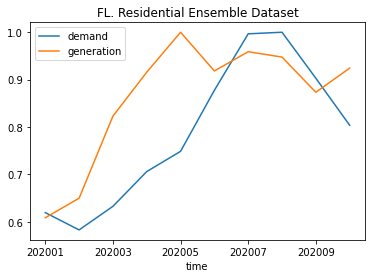

In [149]:
# Data Gathering Settings
api_key='d42ebe76b736d7815489e3298ff17079'
start ='202001'
end = '202012'
eia_url = 'http://api.eia.gov/series/'

# Series
eia_fpl_series = [
    {
        'type':'demand',
        'series':'ELEC.SALES.FL-RES.M'
    },
    {
        'type':'generation',
        'series':'ELEC.GEN.DPV-FL-8.M'
    },
    {
        'type':'price',
        'series':'ELEC.PRICE.FL-RES.M'
    }
    #'EBA.FLA-ALL.D.H',
    #'solar_gen':'EBA.FLA-ALL.NG.SUN.H',
]

datasets = []
for entry in eia_fpl_series:
    series = entry['series']
    url = f'{eia_url}?api_key={api_key}&series_id={series}&start={start}&end={end}'
    data = requests.get(url).json()['series'][0]['data']
    df = pd.DataFrame(data,columns=['time',entry['type']])
    datasets.append(df)

# merge the datasets
df = reduce(lambda  left,right: pd.merge(left,right,on=['time'],how='outer'), datasets)

# apply conversion of units
df['demand'] = df['demand'].apply(lambda x: x*pow(10,6))
df['generation'] = df['generation'].apply(lambda x: x*pow(10,6))

#print(df)

# normalize into percentages 
df['demand'] = df['demand'].apply(lambda x: x/df['demand'].max())
df['generation'] = df['generation'].apply(lambda x: x/df['generation'].max())
df= df.sort_values(by=['time'])

print(df)

#plot the data
df.plot(x='time',y=['demand','generation'],title="FL. Residential Ensemble Dataset")

## Synthesizing Individual Prosumer data from an Ensemble Datasets

> Typical individual consumption per month in florida : 1100kWh/mo.

The datasets collected are monthly averages rolled up for the entire state of florida. 
The florida data can be used as a baseline to show variations each month from a norm.
The average consumer demand in florida was estimated to be 1100kWh a month. Since we have a percentage of the average home usage we can use it as our baseline deviation from norm. 

> Typical individual solar generation per month in florida : (10kW) * 4hr*30days = 1200kWh/mo.

Most florida prosumers are using residential PV installations that are considered Tier 1, less than 10kW AC capacity. By multiplying the possible generation accross the hours of optimum daylight each day (assumption made from surveys) (4 hours * ~30days) we can arrive at an approximate normal capacity for a typical home at around 1200kWh a month. The florida regulations for net metering prohibits the generation of more than 115% of the homes consumption. This limitation fits the benchmarks chosen for an everage prosumers generation, in this case (1,125kWh/mo.).



Prosumer:1
|   time |   price |   generation |   demand |   net_energy |   net_meter |
|--------|---------|--------------|----------|--------------|-------------|
| 202001 |   11.73 |      777.014 |  781.648 |      4.63453 |    0.543631 |
| 202002 |   11.76 |      848.314 |  715.613 |      0       |    0        |
| 202003 |   11.64 |      988.233 |  565.324 |      0       |    0        |
| 202004 |   11.71 |      888.449 |  594.336 |      0       |    0        |
| 202005 |    9.84 |     1070.58  |  901.958 |      0       |    0        |
| 202006 |   11.53 |     1200     |  855.378 |      0       |    0        |
| 202007 |   11.71 |     1071.06  |  633.234 |      0       |    0        |
| 202008 |   11.61 |     1185.15  | 1506.59  |    321.44    |   37.3192   |
| 202009 |   11.97 |     1069.07  |  850.303 |      0       |    0        |
| 202010 |   11.49 |      795.466 |  623.386 |      0       |    0        |

Prosumer:2
|   time |   price |   generation |   demand |   net_energy |   

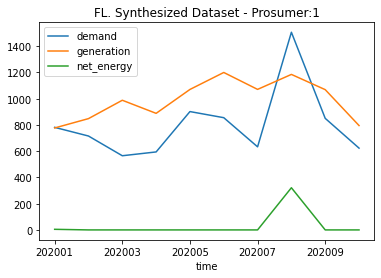

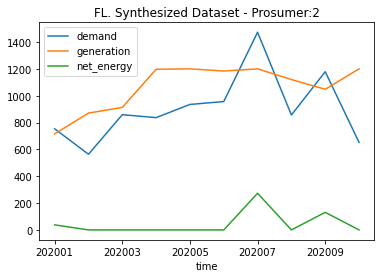

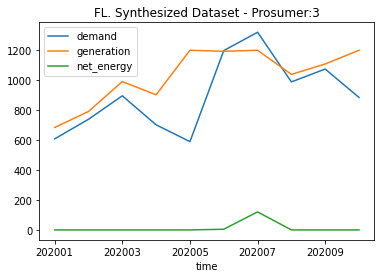

In [150]:
# Generate a collection of prosumers
N = 3 # Number of prosumers to create

# set some constants for the build
init = [
        {
            'type':'generation',
            'mean':1200,
            'std': 1200 * 0.2, #20% of mean,
            'ulim':1200, # upper limit (capacity),
            'llim':0 # lower limit 
        },
        {   
            'type':'demand',
            'mean':1100,
            'std': 1100 * 0.2, #20% of mean
            'ulim':1100 * 2, # upper limit (max load),
            'llim':1100 * 0.1 # lower limit (constant load) 
        } 
    ]


def get_curve(curve,mean,std,ulim,llim):
    return 

prosumers = []
for n in range(N):
    pro_datasets = []
    # Create a price column
    pro_datasets.append(df[['time','price']])
    # Create the generation and demand columns    
    for conf in init:
        curve = df[conf['type']]
        c = [max(conf['llim'],min(conf['ulim'],
        random.normal(loc=conf['mean'],scale=conf['std'])*x)) for x in curve]
        df_t = pd.DataFrame(list(zip(df['time'],c)),columns=['time',conf['type']])
        pro_datasets.append(df_t)
     # merge the datasets
    df_p = reduce(lambda  left,right: pd.merge(left,right,on=['time'],how='outer'), pro_datasets)
    # Add net energy from demand and generation cols
    net_energy = df_p['demand'] - df_p['generation']
    net_energy_cap = [max(x,0) for x in net_energy]
    time_n_net_energy = list(zip(df['time'],net_energy_cap))
    df_net = pd.DataFrame(time_n_net_energy,columns=['time','net_energy'])
    df_pn = df_p.merge(df_net,on='time')
    # Create the profit from net metering
    # conver to dollars from cents
    net_meter = df_pn['net_energy']*(0.01*df_pn['price'])
    time_n_net_meter = list(zip(df['time'],net_meter))
    df_net_met = pd.DataFrame(time_n_net_meter,columns=['time','net_meter'])
    df_m = df_pn.merge(df_net_met,on='time')
    

    prosumers.append({"id":n+1,"data":df_m})


#plot the prosumers
for prosumer in prosumers:
    print(f"\nProsumer:{prosumer['id']}")
    print(tabulate(prosumer['data'], headers = 'keys', tablefmt = 'github',showindex=False))
    prosumer['data'].plot(x='time',y=['demand','generation','net_energy'],title=f"FL. Synthesized Dataset - Prosumer:{prosumer['id']}")
    

Create a merger of the datasets and generate the net energy. The net energy would be any exccess energy when generation is subtracted from load. 

The real time pricing each month is determined from the dataset and the net energy. 

Balance for net metering can be provided here for each prosumer. 

|   Prosumer |   Total Profit ($) |   Total Net Energy (kWh) |
|------------|--------------------|--------------------------|
|          1 |            37.8628 |                  326.074 |
|          2 |            52.0425 |                  441.456 |
|          3 |            14.6183 |                  124.905 |


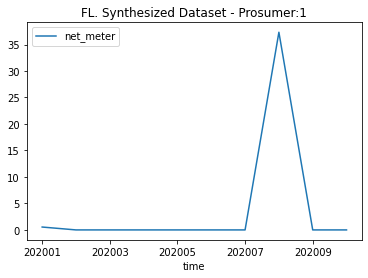

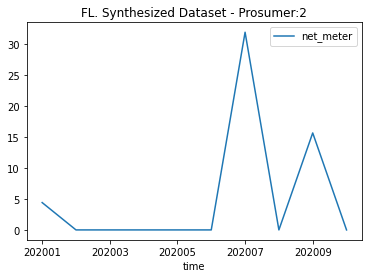

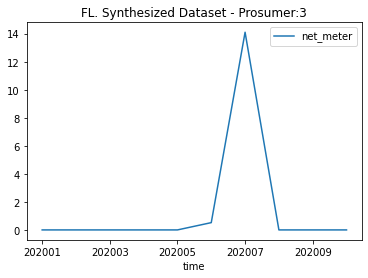

In [154]:
sheet = []
for prosumer in prosumers:
    total_profit = prosumer['data']['net_meter'].sum()
    total_net_energy= prosumer['data']['net_energy'].sum()
    sheet.append({'Prosumer':prosumer['id'],'Total Profit ($)':total_profit,'Total Net Energy (kWh)':total_net_energy})
    prosumer['data'].plot(x='time',y=['net_meter'],title=f"FL. Synthesized Dataset - Prosumer:{prosumer['id']}")

print(tabulate(sheet, headers = 'keys', tablefmt = 'github',showindex=False))    